In [1]:
import glob
import os
from os.path import join
import sys
import pandas as pd
import pyarrow.parquet as pq
import json

from dotenv import load_dotenv
load_dotenv(override=True)

from utils import get_all_directories
import pprint
from tqdm import tqdm

import numpy as np

GITTABLES = os.path.normpath('/ext/daten-wi/wi20b/gittables/')


# Install all needed dependencies
pip install pandas tqdm pyarrow python-dotenv matplotlib

In [2]:
json.loads(pq.read_schema("./data/abstraction_tables/Designite_SubSonic.SubStage_DesignSmells.parquet").metadata[b"gittables"])["dbpedia_embedding_column_types"]

{'Design smell': {'cleaned_label': 'odor',
  'description': None,
  'domain': None,
  'id': 'http://dbpedia.org/ontology/odor',
  'range': ['http://www.w3.org/2001/XMLSchema#string'],
  'superproperty': None},
 'Class': {'cleaned_label': 'class',
  'description': None,
  'domain': None,
  'id': 'http://dbpedia.org/ontology/class',
  'range': None,
  'superproperty': ['http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#isClassifiedBy']},
 'File': {'cleaned_label': 'file extension',
  'description': None,
  'domain': ['http://dbpedia.org/ontology/File'],
  'id': 'http://dbpedia.org/ontology/fileExtension',
  'range': ['http://www.w3.org/2001/XMLSchema#string'],
  'superproperty': None},
 'Cause': {'cleaned_label': 'death cause',
  'description': None,
  'domain': ['http://dbpedia.org/ontology/Person'],
  'id': 'http://dbpedia.org/ontology/deathCause',
  'range': None,
  'superproperty': ['http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#coparticipatesWith']}}

In [3]:
json.loads(pq.read_schema("./data/abstraction_tables/Designite_SubSonic.SubStage_DesignSmells.parquet").metadata[b"gittables"])["dtypes"]

{'Design smell': 'object',
 'Namespace': 'object',
 'Class': 'object',
 'File': 'object',
 'Cause': 'object'}

In [10]:
# Jos: haben wir gemacht; liest die Tabellen einmal ein und erstellt dazu gehörige Metriken

gittable_dirs = get_all_directories(join(GITTABLES, "data"))

for gittable_dir in gittable_dirs:
    textual_types = []
    numerical_types = []
    semantic_types = []
    results = []
    print(gittable_dir)
    all_tables = glob.glob(f"./data/{gittable_dir}/*.parquet")
    with tqdm(total=len(all_tables)) as pbar:
        for table in all_tables:
            try:
                pandas_table = pd.read_parquet(table)

                textual_cols = 0
                numerical_cols = 0

                pandas_table = pandas_table.dropna(axis=0, how='all')
                pandas_table = pandas_table.dropna(axis=1, how='all')
                

                for col in pandas_table.columns:              
                    if(pd.api.types.is_string_dtype(pandas_table[col].dtype)):
                        textual_cols += 1
                    else:
                        numerical_cols += 1

            except:
                pass
            results.append([table, textual_cols, numerical_cols, textual_cols+numerical_cols, pandas_table.shape[0]])
            pbar.update(1)
        

    df = pd.DataFrame(results, columns=["table", "#textual_cols", "#numerical_cols", "#cols", "#rows"])
    df.to_csv(f"./data/_cleaned/{gittable_dir}_stats_cleaned.csv", index=False)
    # with open(f"./data/_cleaned/{gittable_dir}_stats_types_cleaned.json", "w") as f:
    #     json.dump({
    #         "textual_types": textual_types,
    #         "numerical_types": numerical_types,
    #         "semantic_types": semantic_types
    #         }, f)        

abstraction_tables


100%|██████████| 22863/22863 [03:48<00:00, 100.03it/s]


physical_entity_tables


100%|██████████| 5622/5622 [01:57<00:00, 47.68it/s] 


dwarf_tables


100%|██████████| 15485/15485 [02:46<00:00, 92.93it/s] 


object_tables


100%|██████████| 365723/365723 [1:14:00<00:00, 82.36it/s] 


id_tables


100%|██████████| 110117/110117 [15:10<00:00, 120.94it/s]


parent_tables


100%|██████████| 385819/385819 [56:43<00:00, 113.35it/s] 


living_thing_tables


100%|██████████| 81800/81800 [16:12<00:00, 84.07it/s] 


thing_tables


100%|██████████| 385459/385459 [1:23:52<00:00, 76.59it/s]  


whole_tables


100%|██████████| 311969/311969 [1:11:59<00:00, 72.23it/s] 


organism_tables


100%|██████████| 16643/16643 [02:53<00:00, 96.05it/s] 


_cleaned


0it [00:00, ?it/s]


# Read the tables from the dictionary; already given
gittable_dirs = get_all_directories(join(GITTABLES, "data"))

for gittable_dir in gittable_dirs[8:]:
    textual_types = []
    numerical_types = []
    semantic_types = []
    results = []
    print(gittable_dir)
    all_tables = glob.glob(f"./data/{gittable_dir}/*.parquet")
    with tqdm(total=len(all_tables)) as pbar:
        for table in all_tables:
            #try:
            #print(table)
            pq_table = pq.read_schema(table)
            #print(pq_table)
            pq_table_metadata = json.loads(pq_table.metadata[b'gittables'])
            #pprint.pprint(pq_table_metadata)
            dbpedia_types = pq_table_metadata["dbpedia_embedding_column_types"]
            dbpedia_similarities = pq_table_metadata["dbpedia_embedding_similarities"]
            
            textual_cols = 0
            numerical_cols = 0
            for dtype in pq_table_metadata["dtypes"].keys():
                try:
                    if dbpedia_similarities[dtype] > 0.0: # in case we want to filter assigned types regarding the similarity score later on
                        if pq_table_metadata["dtypes"][dtype] == "object" or pq_table_metadata["dtypes"][dtype] == "string":
                            textual_cols += 1
                            textual_types.append(dbpedia_types[dtype]["cleaned_label"])
                        else:
                            numerical_cols += 1
                            numerical_types.append(dbpedia_types[dtype]["cleaned_label"])
                except:
                    pass
            
            results.append([table, textual_cols, numerical_cols, textual_cols+numerical_cols, pq_table_metadata["number_rows"]])
            #except:
            #    pass
            pbar.update(1)

    #df = pd.DataFrame(results, columns=["table", "#textual_cols", "#numerical_cols", "#cols", "#rows"])
    #df.to_csv(f"./data/{gittable_dir}_stats.csv", index=False)
    # with open(f"./data/{gittable_dir}_stats_types.json", "w") as f:
    #     json.dump({
    #         "textual_types": textual_types,
    #         "numerical_types": numerical_types,
    #         "semantic_types": semantic_types
    #         }, f)
    

In [2]:
#### read in the seperated stats files
gittable_dirs = get_all_directories(join(GITTABLES, "data"))
dfs = []
semantic_types = []
textual_types = []
numerical_types = []
for gittable_dir in gittable_dirs:
    df = pd.read_csv(f"./data/_cleaned/{gittable_dir}_stats_cleaned.csv") # TODO Jos Anpassung Ordner
    df["gittables_dir"] = gittable_dir
    dfs.append(df)
    
    # with open(f"./data/{gittable_dir}_stats_types.json") as f: 
    #     sem_types_file = json.load(f)
    #     semantic_types.extend(sem_types_file["semantic_types"])
    #     textual_types.extend(sem_types_file["textual_types"])
    #     numerical_types.extend(sem_types_file["numerical_types"])
        

df = pd.concat(dfs, ignore_index=True)

In [3]:
# Outcome dataframe containing the useful information
df

,table,#textual_cols,#numerical_cols,#cols,#rows,gittables_dir
0,./data/abstraction_tables/13-14_108.parquet,5,6,11,149,abstraction_tables
1,./data/abstraction_tables/Designite_NServiceKi...,5,0,5,9,abstraction_tables
2,./data/abstraction_tables/1_115.parquet,4,1,5,30,abstraction_tables
3,./data/abstraction_tables/Designite_LinqPadDri...,5,0,5,9,abstraction_tables
4,./data/abstraction_tables/Designite_BiM.MITM_D...,5,0,5,7,abstraction_tables
...,...,...,...,...,...,...
1701495,./data/organism_tables/12.1%20%EA%B3%BC%ED%95%...,2,0,2,132,organism_tables
1701496,./data/organism_tables/Germany_Bacteroides.coa...,12,2,14,6,organism_tables
1701497,./data/organism_tables/representatives_NUniver...,2,5,7,203,organism_tables
1701498,./data/organism_tables/05-06_36.parquet,5,6,11,93,organism_tables


In [4]:
# filter out tables, that have no labeled columns
df = df[(df["#cols"] != 0) & (df["#rows"] != 0)] 
#df = df[(df["#cols"] != 0)] 
df

,table,#textual_cols,#numerical_cols,#cols,#rows,gittables_dir
0,./data/abstraction_tables/13-14_108.parquet,5,6,11,149,abstraction_tables
1,./data/abstraction_tables/Designite_NServiceKi...,5,0,5,9,abstraction_tables
2,./data/abstraction_tables/1_115.parquet,4,1,5,30,abstraction_tables
3,./data/abstraction_tables/Designite_LinqPadDri...,5,0,5,9,abstraction_tables
4,./data/abstraction_tables/Designite_BiM.MITM_D...,5,0,5,7,abstraction_tables
...,...,...,...,...,...,...
1701495,./data/organism_tables/12.1%20%EA%B3%BC%ED%95%...,2,0,2,132,organism_tables
1701496,./data/organism_tables/Germany_Bacteroides.coa...,12,2,14,6,organism_tables
1701497,./data/organism_tables/representatives_NUniver...,2,5,7,203,organism_tables
1701498,./data/organism_tables/05-06_36.parquet,5,6,11,93,organism_tables


In [5]:
# TODO Jos add new column showing the percentage of numerical columns of all columns
df["percentnumcol"] = (df["#numerical_cols"] / df["#cols"])

/tmp/ipykernel_1933636/3118306296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["percentnumcol"] = (df["#numerical_cols"] / df["#cols"])


In [6]:
# Jos Filter out every table that has less than "85 %" of the columns numeric
df2 = df[df["percentnumcol"] > 0.8]
df2 = df2[df2["#rows"] > 25]
df2

,table,#textual_cols,#numerical_cols,#cols,#rows,gittables_dir,percentnumcol
221,./data/abstraction_tables/pred_stats_ctl_lengt...,1,20,21,151,abstraction_tables,0.952381
882,./data/abstraction_tables/predictive_stats_pre...,1,20,21,151,abstraction_tables,0.952381
1073,./data/abstraction_tables/predictive_stats_ran...,1,20,21,151,abstraction_tables,0.952381
1177,./data/abstraction_tables/pred_stats_ctl_lengt...,1,20,21,151,abstraction_tables,0.952381
1358,./data/abstraction_tables/cochange_stats_rando...,1,19,20,155,abstraction_tables,0.95
...,...,...,...,...,...,...,...
1701393,./data/organism_tables/yrbG-kdsDC-lptCAB-rpoN-...,1,33,34,33,organism_tables,0.970588
1701419,./data/organism_tables/atpIBEFHAGDC.parquet,1,35,36,35,organism_tables,0.972222
1701477,./data/organism_tables/Raltegravir%20100%20mg%...,0,5,5,165,organism_tables,1.0
1701481,./data/organism_tables/glgBXCAP_splits_1.parquet,1,21,22,33,organism_tables,0.954545


In [7]:
testdf = df2[(df2["#numerical_cols"] < 18) & (df2['#textual_cols'] > 2)]
testdf

,table,#textual_cols,#numerical_cols,#cols,#rows,gittables_dir,percentnumcol
31648,./data/dwarf_tables/race_15.parquet,3,16,19,64,dwarf_tables,0.842105
32394,./data/dwarf_tables/SetB.parquet,3,16,19,281,dwarf_tables,0.842105
35232,./data/dwarf_tables/elements20210226.parquet,3,15,18,118,dwarf_tables,0.833333
41249,./data/dwarf_tables/elements20210227.parquet,3,15,18,118,dwarf_tables,0.833333
55140,./data/object_tables/rq2-results-script.parquet,3,17,20,287,object_tables,0.85
...,...,...,...,...,...,...,...
1691424,./data/organism_tables/stats_by_exp_8_2.parquet,4,17,21,150,organism_tables,0.809524
1693039,./data/organism_tables/stats_by_exp_10_2.parquet,4,17,21,150,organism_tables,0.809524
1694911,./data/organism_tables/stats_by_exp_8_4.parquet,4,17,21,150,organism_tables,0.809524
1697618,./data/organism_tables/AssemblyStats.parquet,4,17,21,107,organism_tables,0.809524


In [8]:
testdf['#cols'].sum()

9668

In [9]:
testdf['#rows'].mean()

191.64591439688715

In [21]:
testdf['#cells'] = [testdf.iloc[i, 3] * testdf.iloc[i, 4] for i in range(0,testdf.shape[0])]

/tmp/ipykernel_1933636/3654768887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['#cells'] = [testdf.iloc[i, 3] * testdf.iloc[i, 4] for i in range(0,testdf.shape[0])]


In [23]:
testdf['#cells'].sum()

1850362

In [16]:
testdf.to_csv('/ext/daten-wi/wi20b/doduo/tables_testdf_2_18.csv')

In [25]:
# Jos Filter out all tables having less than 18 numeric and 3 textual columns
df3 = df2[(df2["#numerical_cols"] > 20) & (df2['#textual_cols'] > 5)]
df3

,table,#textual_cols,#numerical_cols,#cols,#rows,gittables_dir,percentnumcol
23278,./data/physical_entity_tables/MH_Survey_Explor...,36,203,239,32,physical_entity_tables,0.849372
25953,./data/physical_entity_tables/MH_Survey_Explor...,36,203,239,32,physical_entity_tables,0.849372
27046,./data/physical_entity_tables/MH_Survey_Explor...,36,203,239,32,physical_entity_tables,0.849372
28721,./data/dwarf_tables/ChrRaces.dbc_3.parquet,6,63,69,26,dwarf_tables,0.913043
28950,./data/dwarf_tables/Betula_data_2015.parquet,6,40,46,146,dwarf_tables,0.869565
...,...,...,...,...,...,...,...
1689117,./data/organism_tables/Search_Data_US_Congress...,13,129,142,32,organism_tables,0.908451
1690908,./data/organism_tables/matching_trait_demo_dat...,6,28,34,90,organism_tables,0.823529
1693091,./data/organism_tables/Search_Data_US_Congress...,13,129,142,32,organism_tables,0.908451
1694454,./data/organism_tables/Pruned_df_Phylum_Cyanob...,7,56,63,29,organism_tables,0.888889


In [23]:
# Jos Sum of all columns after filter application
df3["#cols"].sum()

42419

In [29]:
df3["#rows"].mean()

83.2637168141593

In [8]:
df[df["#textual_cols"] > 1]

,table,#textual_cols,#numerical_cols,#cols,#rows,gittables_dir


In [16]:
# export of the list of filtered columns to use in dataprep notebook; number stands for used percentage of numeric columns
df3.to_csv('/ext/daten-wi/wi20b/doduo/tables0_8_70_clean.csv')

# Everything afterwards is not written from us and was not looked at at all

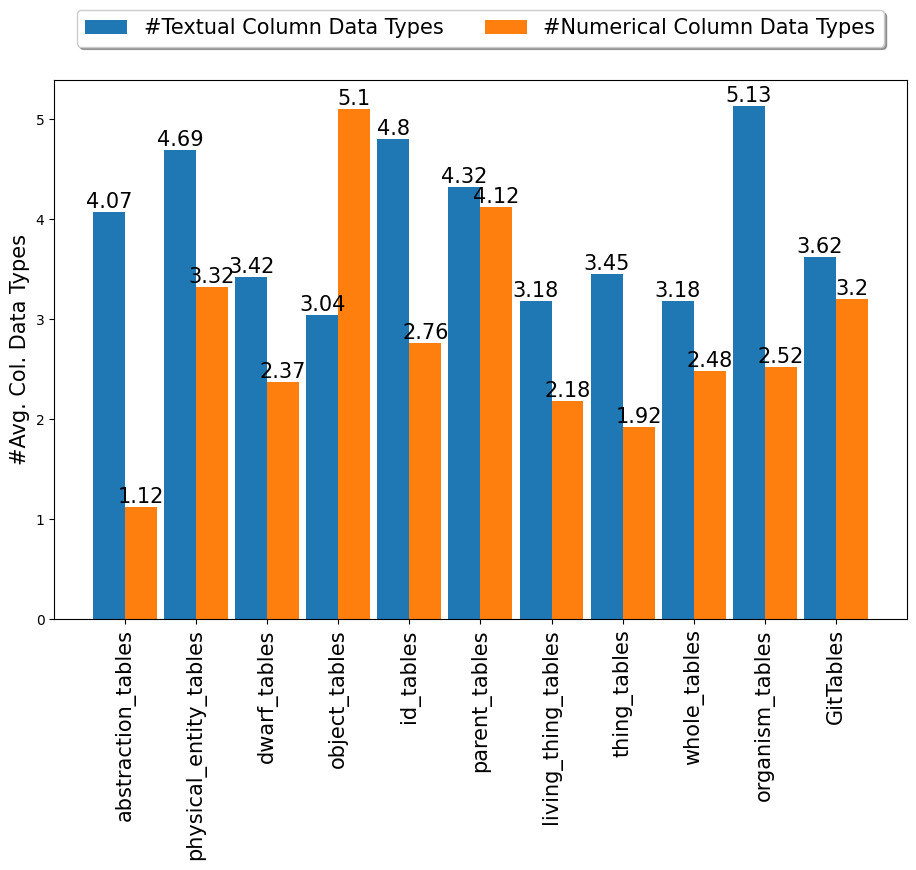

In [16]:
from matplotlib import pyplot as plt

width = 0.45

fig, ax = plt.subplots(figsize=(11,7))

rects = []

## round specific plot
for idx,gittable_dir in enumerate(gittable_dirs):
    rects.append(ax.bar([idx-width/2], [round(df[df["gittables_dir"] == gittable_dir]["#textual_cols"].mean(),2)], width=width, label="#Textual Column Data Types", color="C0"))
    rects.append(ax.bar([idx+width/2], [round(df[df["gittables_dir"] == gittable_dir]["#numerical_cols"].mean(),2)], width=width, label="#Numerical Column Data Types", color="C1"))


## total bar plot
rects.append(ax.bar([idx+1-width/2], [round(df["#textual_cols"].mean(),2)], width=width, label="#Textual Column Data Types"))
rects.append(ax.bar([idx+1+width/2], [round(df["#numerical_cols"].mean(),2)], width=width, label="#Numerical Column Data Types"))

fontsize = 15
for rect in rects:
    ax.bar_label(rect, fontsize=fontsize)
    
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10],gittable_dirs+["GitTables"], fontsize=fontsize, rotation=90)
#ax.set_yticks(ax.get_yticks(),ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel("#Avg. Col. Data Types", fontsize=fontsize)
ax.legend(handles=[rects[0], rects[1]], fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5,1.15), ncol=2, fancybox=True,shadow=True)
plt.show()

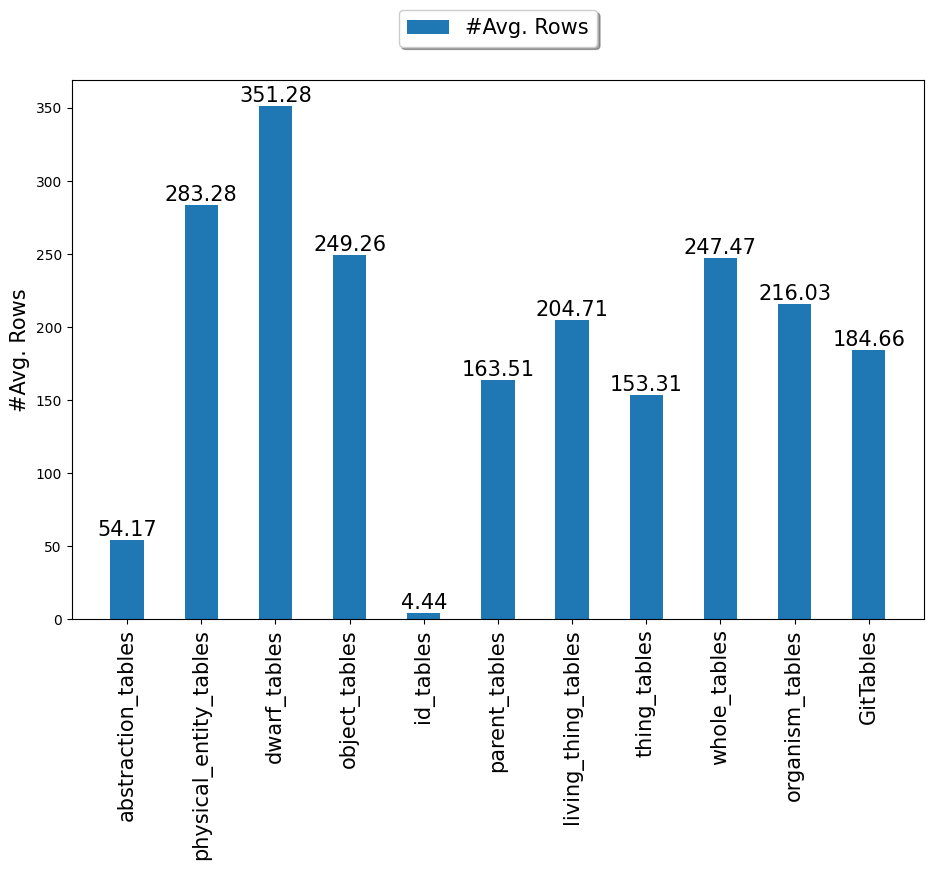

In [17]:
from matplotlib import pyplot as plt

width = 0.45

fig, ax = plt.subplots(figsize=(11,7))

rects = []

## domain specific plot
for idx,gittable_dir in enumerate(gittable_dirs):
    rects.append(ax.bar([idx], [round(df[df["gittables_dir"] == gittable_dir]["#rows"].mean(),2)], width=width, label="#Avg. Rows", color="C0"))

## total bar plot
rects.append(ax.bar([idx+1], [round(df["#rows"].mean(),2)], width=width))

fontsize = 15
for rect in rects:
    ax.bar_label(rect, fontsize=fontsize)
    
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10],gittable_dirs+["GitTables"], fontsize=fontsize, rotation=90)
#ax.set_yticks(ax.get_yticks(),ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel("#Avg. Rows", fontsize=fontsize)
ax.legend(handles=[rects[0]], fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5,1.15), ncol=2, fancybox=True,shadow=True)
plt.show()

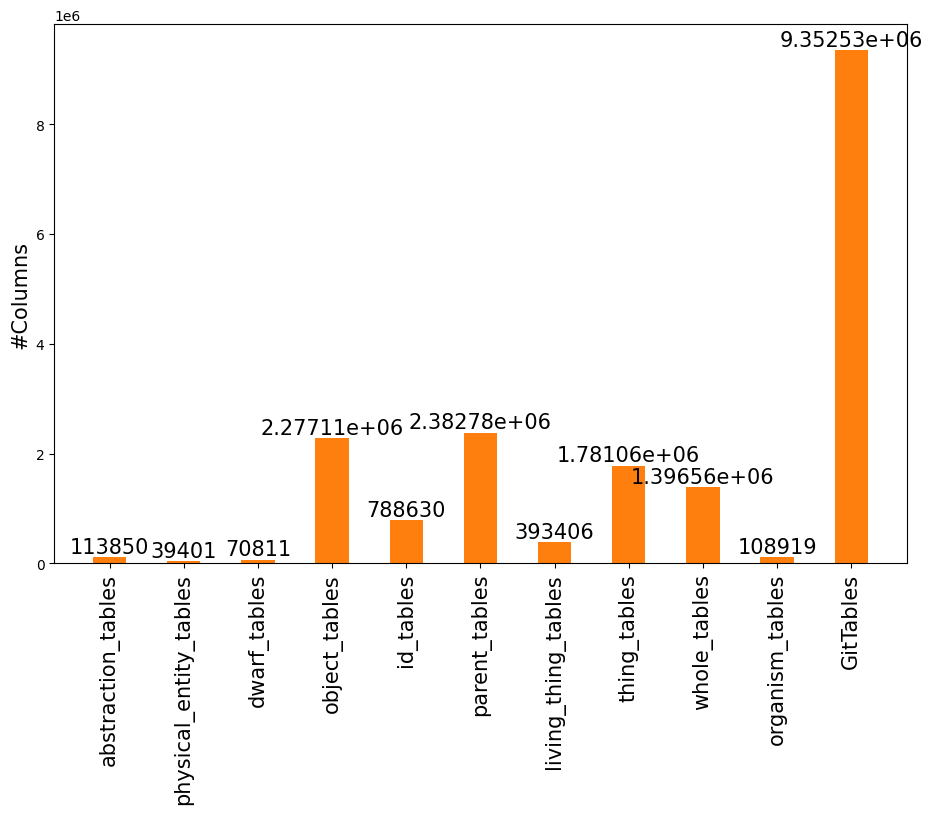

In [18]:
from matplotlib import pyplot as plt

width = 0.45

fig, ax = plt.subplots(figsize=(11,7))

rects = []

## round specific plot
for idx,gittable_dir in enumerate(gittable_dirs):
    rects.append(ax.bar([idx], [df[df["gittables_dir"] == gittable_dir]["#cols"].sum()], width=width, label="#Cols", color="C1"))


## total bar plot
rects.append(ax.bar([idx+1], [df["#cols"].sum()], width=width, color="C1"))

fontsize = 15
for rect in rects:
    ax.bar_label(rect, fontsize=fontsize)
    
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10],gittable_dirs+["GitTables"], fontsize=fontsize, rotation=90)
#ax.set_yticks(ax.get_yticks(),ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel("#Columns", fontsize=fontsize)
#ax.legend(handles=[rects[0]], fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5,1.15), ncol=2, fancybox=True,shadow=True)
plt.show()

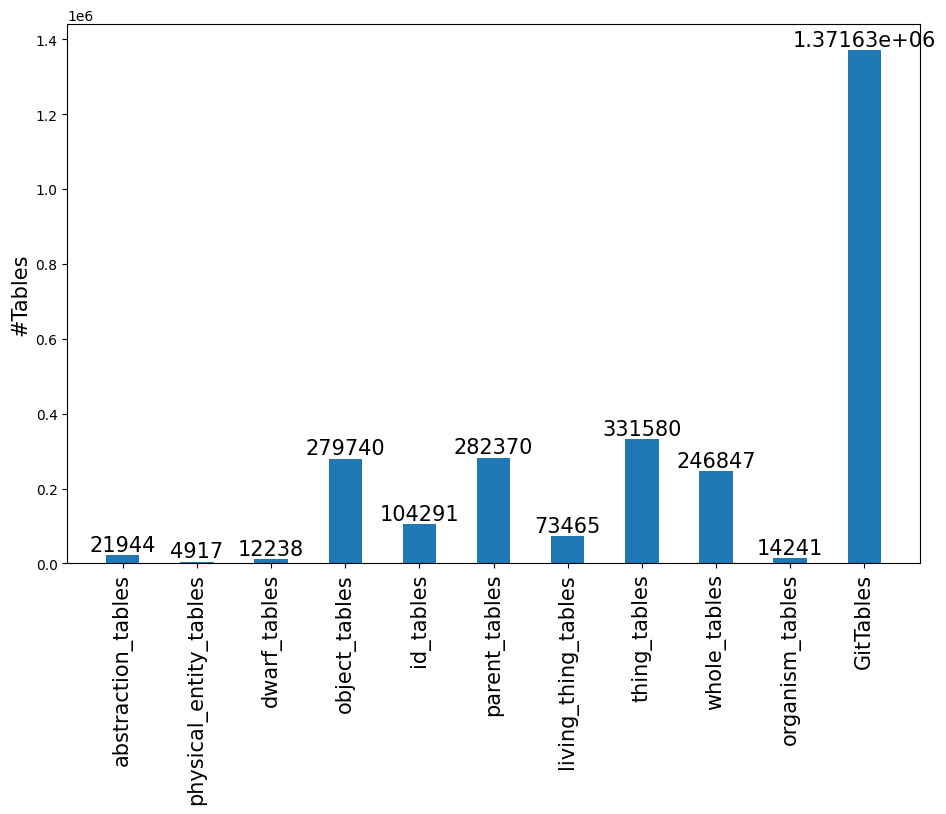

In [19]:
from matplotlib import pyplot as plt

width = 0.45

fig, ax = plt.subplots(figsize=(11,7))

rects = []

## round specific plot
for idx,gittable_dir in enumerate(gittable_dirs):
    rects.append(ax.bar([idx], [len(df[df["gittables_dir"] == gittable_dir])], width=width, label="#Tables", color="C0"))

## total bar plot
rects.append(ax.bar([idx+1], [len(df)], width=width, color="C0"))

fontsize = 15
for rect in rects:
    ax.bar_label(rect, fontsize=fontsize)
    
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10],gittable_dirs+["GitTables"], fontsize=fontsize, rotation=90)
#ax.set_yticks(ax.get_yticks(),ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel("#Tables", fontsize=fontsize)
#ax.legend(handles=[rects[0]], fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5,1.15), ncol=2, fancybox=True,shadow=True)
plt.show()

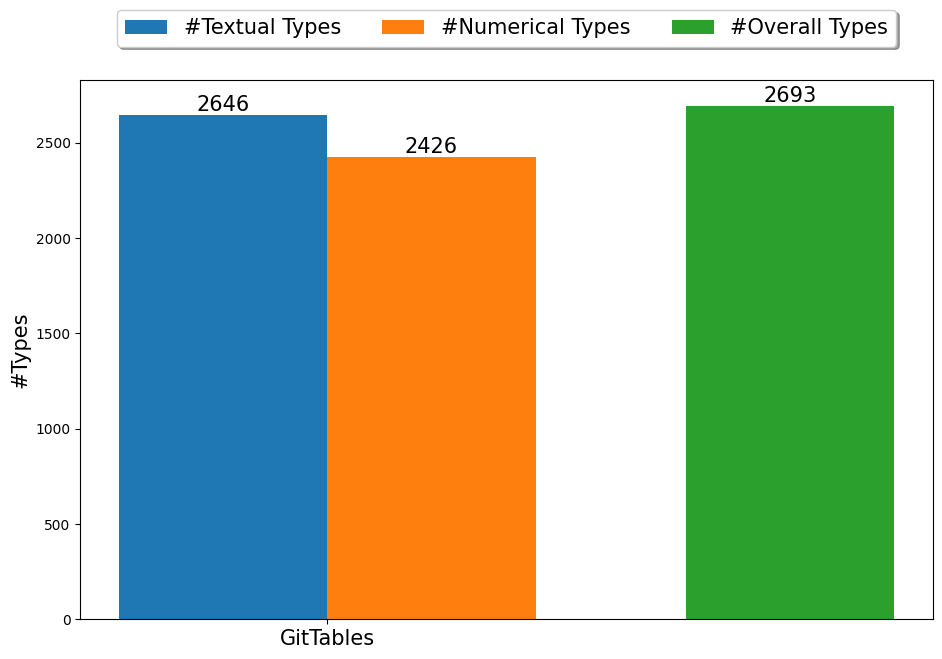

In [20]:
from collections import Counter

counts = Counter(textual_types)

df_textual_types = pd.DataFrame({"semantic_type": list(counts.keys()), "#":list(counts.values())})

counts = Counter(numerical_types)

df_numeric_types = pd.DataFrame({"semantic_type": list(counts.keys()), "#":list(counts.values())})

counts = Counter(textual_types+numerical_types)

df_total_types = pd.DataFrame({"semantic_type": list(counts.keys()), "#":list(counts.values())})

from matplotlib import pyplot as plt

width = 0.45

fig, ax = plt.subplots(figsize=(11,7))

rects = []


## total bar plot
rects.append(ax.bar([0-width/2], [len(df_textual_types)], width=width, color="C0", label="#Textual Types"))
rects.append(ax.bar([0+width/2], [len(df_numeric_types)], width=width, color="C1", label="#Numerical Types"))
rects.append(ax.bar([1], [len(df_total_types)], width=width, color="C2", label="#Overall Types"))

fontsize = 15
for rect in rects:
    ax.bar_label(rect, fontsize=fontsize)
    
ax.set_xticks([0],["GitTables"], fontsize=fontsize)
#ax.set_yticks(ax.get_yticks(),ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel("#Types", fontsize=fontsize)
ax.legend(handles=[rects[0], rects[1], rects[2]], fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5,1.15), ncol=3, fancybox=True,shadow=True)
plt.show()

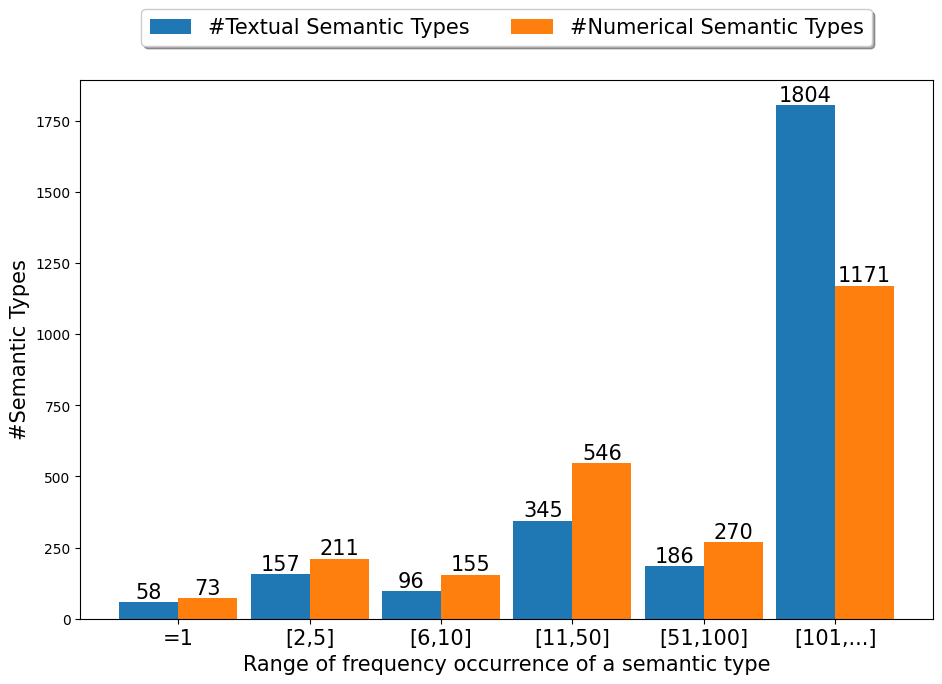

In [21]:
df_numeric_types["data_type"] = "numerical_types"
df_textual_types["data_type"] = "textual_types"
df = pd.concat([df_numeric_types, df_textual_types], ignore_index=True)

from matplotlib import pyplot as plt

width = 0.45

fig, ax = plt.subplots(figsize=(11,7))

rects = []


## total bar plot

rects.append(ax.bar([0-width/2], [len(df[(df["data_type"] == "textual_types") & (df["#"] == 1)])], width=width, color="C0", label="#Textual Semantic Types"))
rects.append(ax.bar([0+width/2], [len(df[(df["data_type"] == "numerical_types") & (df["#"] == 1)])], width=width, color="C1", label="#Numerical Semantic Types"))

rects.append(ax.bar([1-width/2], [len(df[(df["data_type"] == "textual_types") & (df["#"] > 1) & (df["#"] < 6)])], width=width, color="C0"))
rects.append(ax.bar([1+width/2], [len(df[(df["data_type"] == "numerical_types") & (df["#"] > 1) & (df["#"] < 6)])], width=width, color="C1"))

rects.append(ax.bar([2-width/2], [len(df[(df["data_type"] == "textual_types") & (df["#"] > 5) & (df["#"] < 11)])], width=width, color="C0"))
rects.append(ax.bar([2+width/2], [len(df[(df["data_type"] == "numerical_types") & (df["#"] > 5) & (df["#"] < 11)])], width=width, color="C1"))

rects.append(ax.bar([3-width/2], [len(df[(df["data_type"] == "textual_types") & (df["#"] > 10) & (df["#"] < 51)])], width=width, color="C0"))
rects.append(ax.bar([3+width/2], [len(df[(df["data_type"] == "numerical_types") & (df["#"] > 10) & (df["#"] < 51)])], width=width, color="C1"))

rects.append(ax.bar([4-width/2], [len(df[(df["data_type"] == "textual_types") & (df["#"] > 50) & (df["#"] < 101)])], width=width, color="C0"))
rects.append(ax.bar([4+width/2], [len(df[(df["data_type"] == "numerical_types") & (df["#"] > 50) & (df["#"] < 101)])], width=width, color="C1"))

rects.append(ax.bar([5-width/2], [len(df[(df["data_type"] == "textual_types") & (df["#"] > 100)])], width=width, color="C0"))
rects.append(ax.bar([5+width/2], [len(df[(df["data_type"] == "numerical_types") & (df["#"] > 100)])], width=width, color="C1"))


fontsize = 15
for rect in rects:
    ax.bar_label(rect, fontsize=fontsize)
    
ax.set_xticks([0,1,2,3,4,5],["=1", "[2,5]", "[6,10]", "[11,50]", "[51,100]","[101,...]"], fontsize=fontsize)
#ax.set_yticks(ax.get_yticks(),ax.get_yticks(), fontsize=fontsize)
ax.set_ylabel("#Semantic Types", fontsize=fontsize)
ax.set_xlabel("Range of frequency occurrence of a semantic type", fontsize=fontsize)
ax.legend(handles=[rects[0], rects[1]], fontsize=fontsize, loc="upper center", bbox_to_anchor=(0.5,1.15), ncol=2, fancybox=True,shadow=True)
plt.show()

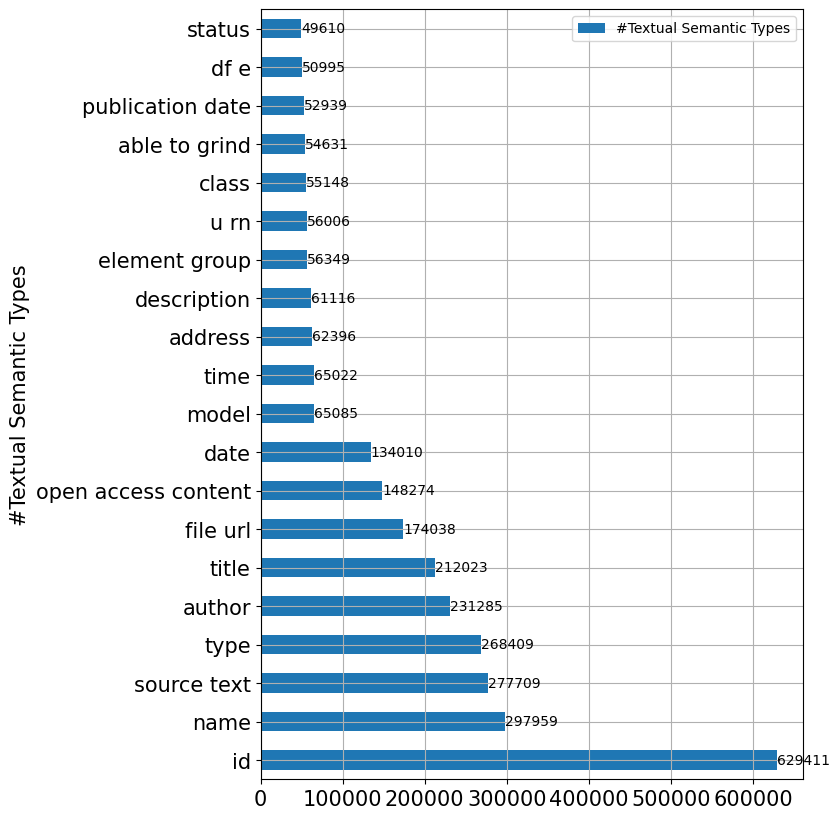

In [22]:
df_plot = df[df["data_type"] == "textual_types"].sort_values(by="#", ascending=False)
#df_plot.plot.barh(x="semantic_type", y="#", figsize=(15,20))
ax = df_plot[:20].plot.barh(x="semantic_type", y="#", figsize=(7,10), label="#Textual Semantic Types")
ax.set_ylabel("#Textual Semantic Types", fontsize=fontsize)
ax.tick_params(axis="both", labelsize=fontsize)
ax.grid()

for container in ax.containers:
    ax.bar_label(container)

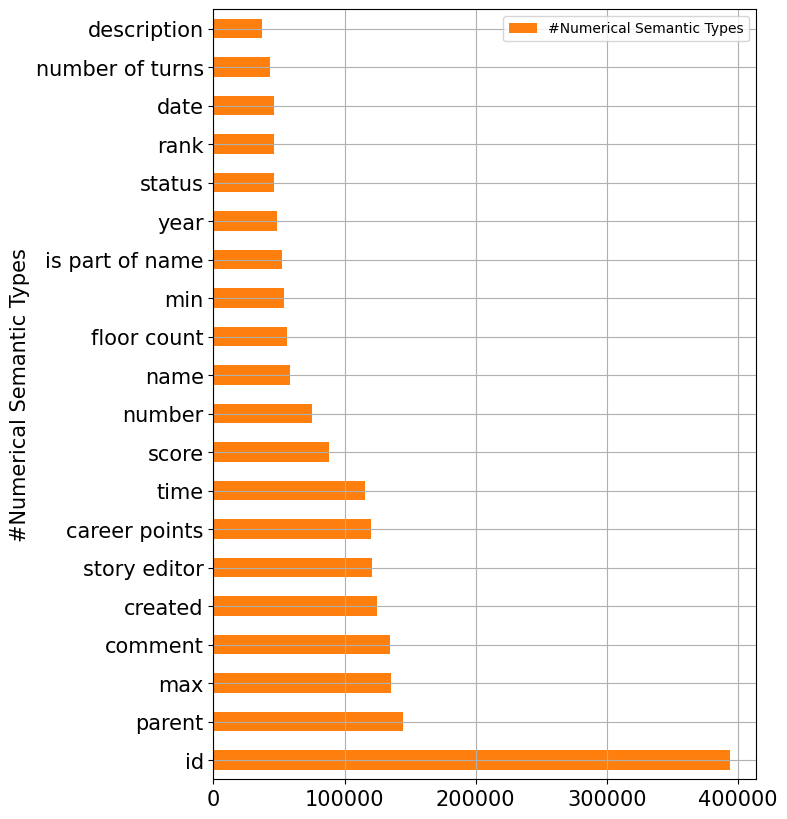

In [23]:
df_plot = df[df["data_type"] == "numerical_types"].sort_values(by="#", ascending=False)
#df_plot.plot.barh(x="semantic_type", y="#", figsize=(15,20))
ax = df_plot[:20].plot.barh(x="semantic_type", y="#", figsize=(7,10), label="#Numerical Semantic Types", color="C1")
ax.set_ylabel("#Numerical Semantic Types", fontsize=fontsize)
ax.tick_params(axis="both", labelsize=fontsize)
ax.grid()

# for container in ax.containers:
#     ax.bar_label(container)